In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

# 设置 matplotlib 以内联显示绘图
%matplotlib inline

In [2]:
print("FDM 求解器：开始...")

# 1. 定义物理和数值参数
k = 1.5       # 导热系数 (W/m·K)
h = 45        # 对流换热系数 (W/m²·K)
T_inf = 30    # 环境温度 (°C)
T_b = 100     # 底部恒温 (°C)
q_flux = 2500 # 左侧热流 (W/m²)

N = 100       # 节点索引从 0 到 100
num_nodes_side = N + 1 # 每侧的节点数 (101)
total_nodes = num_nodes_side * num_nodes_side # 总节点数 (10201)
ds = 0.001    # 网格间距 (0.1 cm = 0.001 m)
L = N * ds    # 域的尺寸 (0.1 m)

print("参数设置完毕。")

# 2. 初始化稀疏矩阵 A 和向量 B
# 使用 LIL (List of Lists) 格式，因为它适合逐个元素填充
A = lil_matrix((total_nodes, total_nodes))
B = np.zeros(total_nodes)

# 3. 填充矩阵 A 和 B
print("正在构建稀疏矩阵 A 和向量 B...")

# 定义一个辅助函数，将 (i, j) 2D 索引转换为 1D 向量索引
def idx(i, j):
    return j * num_nodes_side + i

# 预先计算常数项
C_flux = (2 * ds * q_flux) / k       #
C_conv_1 = (2 * h * ds) / k          #
C_conv_2 = C_conv_1 * T_inf        #

# 遍历所有网格点 (i, j)
for j in range(num_nodes_side): # y-direction
    for i in range(num_nodes_side): # x-direction
        k_1d = idx(i, j) # 当前节点的 1D 索引

        # (A) 底部：恒温边界 (j=0)
        if j == 0:
            A[k_1d, k_1d] = 1.0
            B[k_1d] = T_b

        # (B) 顶部：对流边界 (j=N)
        elif j == N:
            # 角点 (单独处理)
            if i == 0: # 左上角 (i=0, j=N)
                A[k_1d, k_1d] = -(4 + C_conv_1)
                A[k_1d, idx(i + 1, j)] = 2.0
                A[k_1d, idx(i, j - 1)] = 2.0
                B[k_1d] = -C_flux - C_conv_2
            elif i == N: # 右上角 (i=N, j=N)
                A[k_1d, k_1d] = -(4 + C_conv_1)
                A[k_1d, idx(i - 1, j)] = 2.0
                A[k_1d, idx(i, j - 1)] = 2.0
                B[k_1d] = -C_conv_2
            else: # 顶部边缘 (0 < i < N, j=N)
                A[k_1d, k_1d] = -(4 + C_conv_1)
                A[k_1d, idx(i + 1, j)] = 1.0
                A[k_1d, idx(i - 1, j)] = 1.0
                A[k_1d, idx(i, j - 1)] = 2.0
                B[k_1d] = -C_conv_2
        
        # (C) 左侧：恒定热流 (i=0, 0 < j < N)
        elif i == 0:
            A[k_1d, k_1d] = -4.0
            A[k_1d, idx(i + 1, j)] = 2.0
            A[k_1d, idx(i, j + 1)] = 1.0
            A[k_1d, idx(i, j - 1)] = 1.0
            B[k_1d] = -C_flux
            
        # (D) 右侧：绝热 (i=N, 0 < j < N)
        elif i == N:
            A[k_1d, k_1d] = -4.0
            A[k_1d, idx(i - 1, j)] = 2.0
            A[k_1d, idx(i, j + 1)] = 1.0
            A[k_1d, idx(i, j - 1)] = 1.0
            B[k_1d] = 0.0

        # (E) 内部节点 (0 < i < N, 0 < j < N)
        else:
            A[k_1d, k_1d] = -4.0
            A[k_1d, idx(i + 1, j)] = 1.0
            A[k_1d, idx(i - 1, j)] = 1.0
            A[k_1d, idx(i, j + 1)] = 1.0
            A[k_1d, idx(i, j - 1)] = 1.0
            B[k_1d] = 0.0

print("矩阵构建完毕。")

# 4. 求解系统
print("正在求解线性系统...")
# 将 A 转换为 CSR (Compressed Sparse Row) 格式，以实现高效的求解
A_csr = A.tocsr()
T_flat = spsolve(A_csr, B)
print("求解完毕。正在重塑结果 T...")

# 5. 将 1D 结果向量重塑为 2D 温度场
# T[j, i] 对应 T(y, x)
T_matrix = T_flat.reshape((num_nodes_side, num_nodes_side))

print("FDM 求解完成。")

FDM 求解器：开始...
参数设置完毕。
正在构建稀疏矩阵 A 和向量 B...
矩阵构建完毕。
正在求解线性系统...
求解完毕。正在重塑结果 T...
FDM 求解完成。


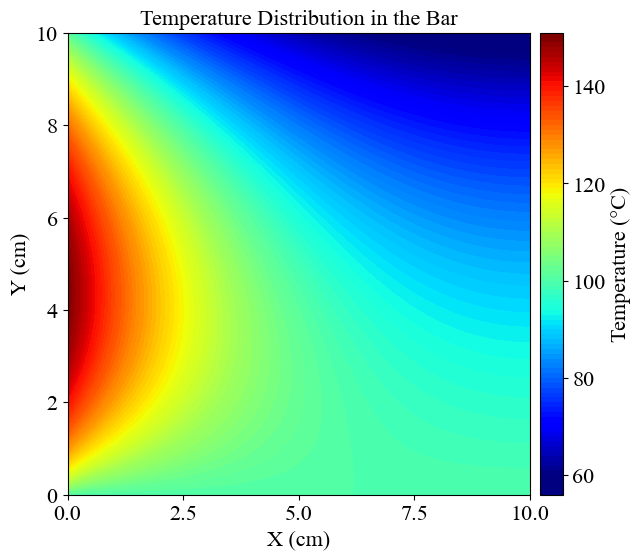

In [20]:
# 导入修复 colorbar 布局所需的工具
# （为防止单元格 1 未运行，在此处重新导入）
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- 开始修改 ---
# 1. 设置字体为衬线字体（如 Times New Roman）
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 # 调整全局字体大小以匹配示例

# 2. 创建坐标网格（单位：厘米）
x_cm = np.linspace(0, L * 100, num_nodes_side)
y_cm = np.linspace(0, L * 100, num_nodes_side)
X_cm, Y_cm = np.meshgrid(x_cm, y_cm)

# 3. 绘制 2D 伪彩图
fig, ax = plt.subplots(figsize=(7, 6))

# 4. 绘制等值线
# *** 修改点 ***
# 133°C 会落在 150 的 88% 处，而不是 140 的 95% 处，颜色会浅一些
c = ax.contourf(X_cm, Y_cm, T_matrix, levels=100, cmap='jet', vmin=60, vmax=150)

# 5. 修复 Colorbar 对齐问题
ax.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
# 6. 将 colorbar 画在新的 cax 轴上
# *** 修改点 ***
# 刻度保持不变，显示到 140
cbar = fig.colorbar(c, cax=cax, ticks=np.arange(60, 151, 20))
cbar.set_label('Temperature (°C)', fontsize=16)

# 7. 设置主图的标签和刻度
ax.set_xlabel('X (cm)', fontsize=16)
ax.set_ylabel('Y (cm)', fontsize=16)
ax.set_title('Temperature Distribution in the Bar', fontsize=16)
ax.set_xticks(np.arange(0, 10.1, 2.5))
ax.set_yticks(np.arange(0, 10.1, 2))
# --- 结束修改 ---

plt.show()

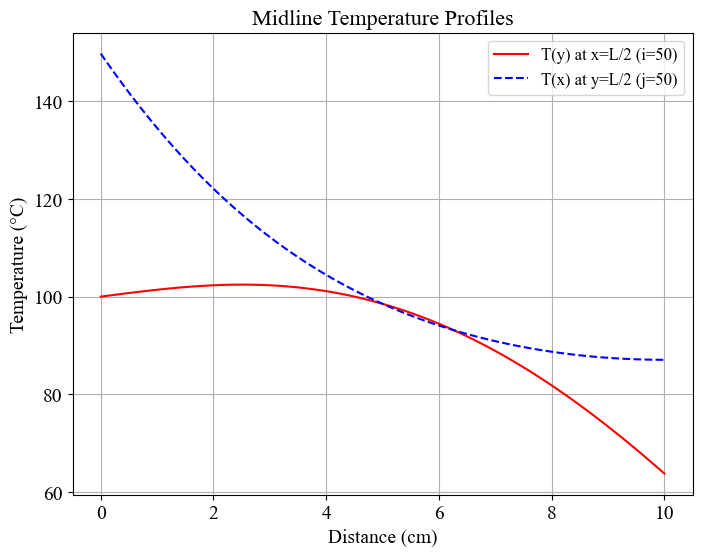

In [8]:
# 字体设置在单元格 3 中已全局生效

# 找到中线的索引
mid_i = N // 2  # x = L/2 (i=50)
mid_j = N // 2  # y = L/2 (j=50)

# 提取中线数据
# T_matrix[j, i]
T_profile_x = T_matrix[mid_j, :]    # T(x) at y=L/2
T_profile_y = T_matrix[:, mid_i]    # T(y) at x=L/2

# 创建坐标用于绘图（单位：厘米）
coords_cm = np.linspace(0, L * 100, num_nodes_side)

# 绘制两条中线剖面
plt.figure(figsize=(8, 6))

plt.plot(coords_cm, T_profile_y, 'r-', label='T(y) at x=L/2 (i=50)')
plt.plot(coords_cm, T_profile_x, 'b--', label='T(x) at y=L/2 (j=50)')

# 设置英文标签、标题和图例
plt.xlabel('Distance (cm)', fontsize=14) # X 轴单位改为 cm
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Midline Temperature Profiles', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()